# Credit Card Transactions

In [24]:
#!pip install tensorflow --upgrade

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lightgbm import plot_importance
%matplotlib inline

#class SilentRegressor(lgb.LGBMRegressor):
#    def fit(self, *args, **kwargs):
#        with warnings.catch_warnings():
#            warnings.filterwarnings("ignore", category=UserWarning)
#            return super().fit(*args, verbose=False, **kwargs)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Set Graph Environment
font = {'family':'Helvetica, Ariel',
        'weight':'normal',
        'size':12}
plt.rc('font', **font)
sns.set_context('notebook')
sns.set_style("ticks")
FIG_FONT = dict(family="Helvetica, Ariel", weight="bold", color="#7f7f7f")
sns.set_palette("Spectral")

In [2]:
# 
cct1 = pd.read_csv('/Users/jasonrobinson/Documents/Projects/All Data/cc-transact-csv/User0_credit_card_transactions.csv')
cct2 =  pd.read_csv('/Users/jasonrobinson/Documents/Projects/All Data/cc-transact-csv/credit_card_transactions-ibm_v2.csv')
cards = pd.read_csv('/Users/jasonrobinson/Documents/Projects/All Data/cc-transact-csv/sd254_cards.csv')
users = pd.read_csv('/Users/jasonrobinson/Documents/Projects/All Data/cc-transact-csv/sd254_users.csv')

In [31]:
# Shape of each dataset
print('\n','    *****SHAPE OF DATA*****','\n',
      '\n',
      'Transactions: -------', cct1.shape,'\n', 
      'Transactions IBM: ---',cct2.shape, '\n',
      'Cards: --------------',cards.shape, '\n', 
      'Users: --------------',users.shape )


     *****SHAPE OF DATA***** 
 
 Transactions: ------- (19963, 15) 
 Transactions IBM: --- (24386900, 15) 
 Cards: -------------- (6146, 13) 
 Users: -------------- (2000, 18)


In [9]:
cct1.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [10]:
cards.head()

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [11]:
users.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [7]:
cct2.isnull().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878135
MCC                      0
Errors?           23998469
Is Fraud?                0
dtype: int64

In [29]:
cct2 = cct2.drop(['Merchant State','Errors?'], axis=1)

In [30]:
cct2.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Zip,MCC,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,91750.0,5300,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,91754.0,5411,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,91754.0,5411,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,91754.0,5651,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,91750.0,5912,No


In [46]:
# Merge dataframe
pd.groupby('')

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 1999, 2000, 2001,
       1998, 1996, 1997, 1995, 1994, 1991, 1992, 1993])

## Preprocessing

In [31]:
#
cct2['Zip'] = cct2['Zip'].fillna(0)
cct2['Amount'] = cct2['Amount'].apply(lambda value: float(value.split("$")[1]))

cct2['Hour'] = cct2['Time'].apply(lambda value: int(value.split(":")[0]))
cct2['Minutes'] = cct2['Time'].apply(lambda value: int(value.split(":")[1]))
cct2.drop(['Time'], axis=1, inplace=True)


cct2['Card'] = cct2['Card'].astype("object")
cct2['Use Chip'] = cct2['Use Chip'].astype("object")

cct2['Merchant Name'] = cct2['Merchant Name'].astype("object")
cct2['MCC'] = cct2['MCC'].astype("object")
cct2['Zip'] = cct2['Zip'].astype("object")

In [32]:
for col in cct2.columns:
    col_type = cct2[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        cct2[col] = cct2[col].astype('category')

In [33]:
# Split our dataset in X and Y
y = cct2['Is Fraud?']
X = cct2.drop(['Is Fraud?'],axis=1)

In [34]:
categorical_column_names = []
categorical_cols = []
for idx,col in enumerate(X.columns):
    col_type = X[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        categorical_column_names.append(col)
        categorical_cols.append(idx)

In [35]:
categorical_column_names.append("Zip")
categorical_column_names.append("MCC")
categorical_column_names.append("Card")
categorical_column_names.append("Merchant Name")

In [36]:
categorical_names = {}
for feature in categorical_column_names:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(X.loc[:, feature])
    X.loc[:, feature] = le.transform(X.loc[:, feature])
    categorical_names[feature] = le.classes_

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    stratify=y)

In [38]:
# Train our lgbm model
model = lgb.LGBMClassifier()
model.fit(X_train, y_train,
          feature_name='auto',
          categorical_feature=categorical_column_names,
          eval_set=[(X_test, y_test)],
          eval_metric='auc',
          early_stopping_rounds=25)

[1]	valid_0's auc: 0.918658	valid_0's binary_logloss: 0.00871861
Training until validation scores don't improve for 25 rounds
[2]	valid_0's auc: 0.898561	valid_0's binary_logloss: 0.00650311
[3]	valid_0's auc: 0.905255	valid_0's binary_logloss: 0.00600996
[4]	valid_0's auc: 0.91251	valid_0's binary_logloss: 0.00593024
[5]	valid_0's auc: 0.912048	valid_0's binary_logloss: 0.00602015
[6]	valid_0's auc: 0.940298	valid_0's binary_logloss: 0.00607977
[7]	valid_0's auc: 0.852506	valid_0's binary_logloss: 0.00906643
[8]	valid_0's auc: 0.947016	valid_0's binary_logloss: 0.00774895
[9]	valid_0's auc: 0.946241	valid_0's binary_logloss: 0.00764013
[10]	valid_0's auc: 0.907285	valid_0's binary_logloss: 0.00787728
[11]	valid_0's auc: 0.905719	valid_0's binary_logloss: 0.00780628
[12]	valid_0's auc: 0.926295	valid_0's binary_logloss: 0.00794891
[13]	valid_0's auc: 0.920786	valid_0's binary_logloss: 0.00810793
[14]	valid_0's auc: 0.923277	valid_0's binary_logloss: 0.00749049
[15]	valid_0's auc: 0.918

LGBMClassifier()

In [7]:
y_pred=model.predict(X_test)

NameError: name 'model' is not defined

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00   7307143
         Yes       0.90      0.64      0.75      8927

    accuracy                           1.00   7316070
   macro avg       0.95      0.82      0.87   7316070
weighted avg       1.00      1.00      1.00   7316070



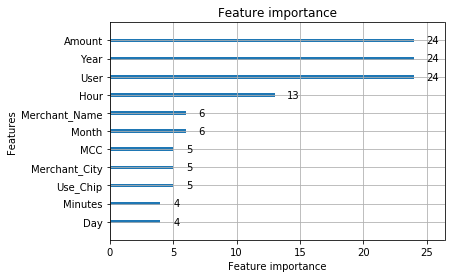

In [41]:
plot_importance(model);

In [5]:
# Save the model to disk
import pickle
clf_model = 'classification_model2.pkl'
pickle.dump(model, open(clf_model, 'wb'))


NameError: name 'model' is not defined

In [4]:
# Load the model from disk
loaded_model = pickle.load(open(clf_model, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

NameError: name 'clf_model' is not defined

In [38]:
# Predict the response for test dataset
y_pred = loaded_model.predict(X_test)

In [39]:
import sklearn.metrics

print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))
#print("Precision:",sklearn.metrics.precision_score(y_test, y_pred))
#print("Recall:",sklearn.metrics.recall_score(y_test, y_pred))
#print("F1:",sklearn.metrics.f1_score(y_test, y_pred))
#print("ROC:",sklearn.metrics.roc_auc_score(y_test, y_pred))
#print("Confusion Matrix:",sklearn.metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9964935715478377


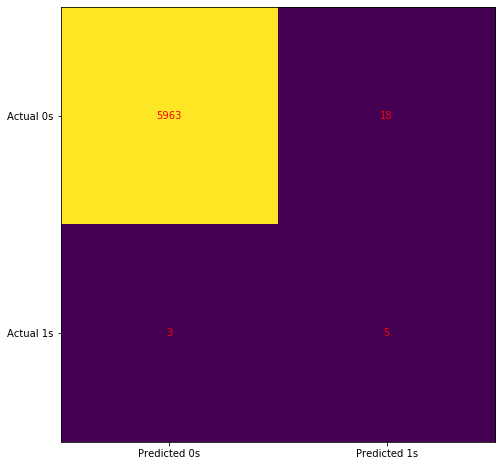

In [40]:
# Create a function to plot the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

In [31]:
# Create a function to plot the ROC curve
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
plot_roc_curve(y_test, y_pred)

NameError: name 'roc_curve' is not defined